In [6]:
import os,sys
sys.path.insert(1, os.path.join(os.getcwd()  , '..'))
import shallowsim as sb
import pandas as pd
import math
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
import time
from tqdm import tqdm, trange


In [7]:
args = sb.ModelArgs()
c = sb.Config()
gpu_all_decode = sb.get_gpu_info('./device/gpu_info.csv',
                                 decoding_mode=True,print_console=True) 

| gpu_type      |   sm |   comm_sm |   fp16 |   fp8 |   fp4 |   mem |   mem_bw |   nvlink_bw |   pcie_bw |   gpu_per_node |
|:--------------|-----:|----------:|-------:|------:|------:|------:|---------:|------------:|----------:|---------------:|
| DGX-B300      |  160 |        20 |   3375 |  7500 | 15000 |   288 |     8000 |         900 |       100 |              8 |
| DGX-B200      |  160 |        20 |   2250 |  4500 |  9000 |   180 |     8000 |         900 |       100 |              8 |
| GB200-NVL72   |  160 |        20 |   2500 |  5000 | 10000 |   192 |     8000 |         900 |       100 |             72 |
| GB300-NVL72   |  160 |        20 |   3750 |  7500 | 15000 |   288 |     8000 |         900 |       100 |             72 |
| Rubin-NVL144  |  110 |        12 |   6400 | 12800 | 25600 |   144 |     6500 |         900 |       100 |            144 |
| RubinU-NVL576 |  110 |        12 |   6500 | 13000 | 26000 |   256 |     8000 |        1350 |       100 |            576 |
| H200  

In [8]:

# generate data
dfs = []
for seq_len in trange(1024,16384,32):
    c.seq_len = seq_len
    df = sb.decode_time_with_ep_list(args,gpu_all_decode,c,fp8_combine=True)
    df['index_value'] = seq_len
    df_o = df.groupby(['GPU','BatchSize','EP'],as_index=False).apply(lambda t: t[t.Total==t.Total.max()]).sort_values(['Total'],ascending=False).reset_index(drop=True)
    df_o.drop_duplicates(subset=['GPU','BatchSize','EP'], keep='first', inplace=True)
    dfs.append(df_o)
df = pd.concat(dfs)    
df.reset_index(inplace=True,drop=True)
df.to_csv('perf_vs_seq_len.csv')


100%|█████████████████████████████████████████████████████████████████████████████████████| 480/480 [05:49<00:00,  1.37it/s]


In [34]:
df = pd.read_csv('perf_vs_seq_len.csv')


In [9]:
#df1 = df[df['EP'] == 144].reset_index(drop=True)
df1 = df[df['BatchSize'] == 128].reset_index(drop=True)

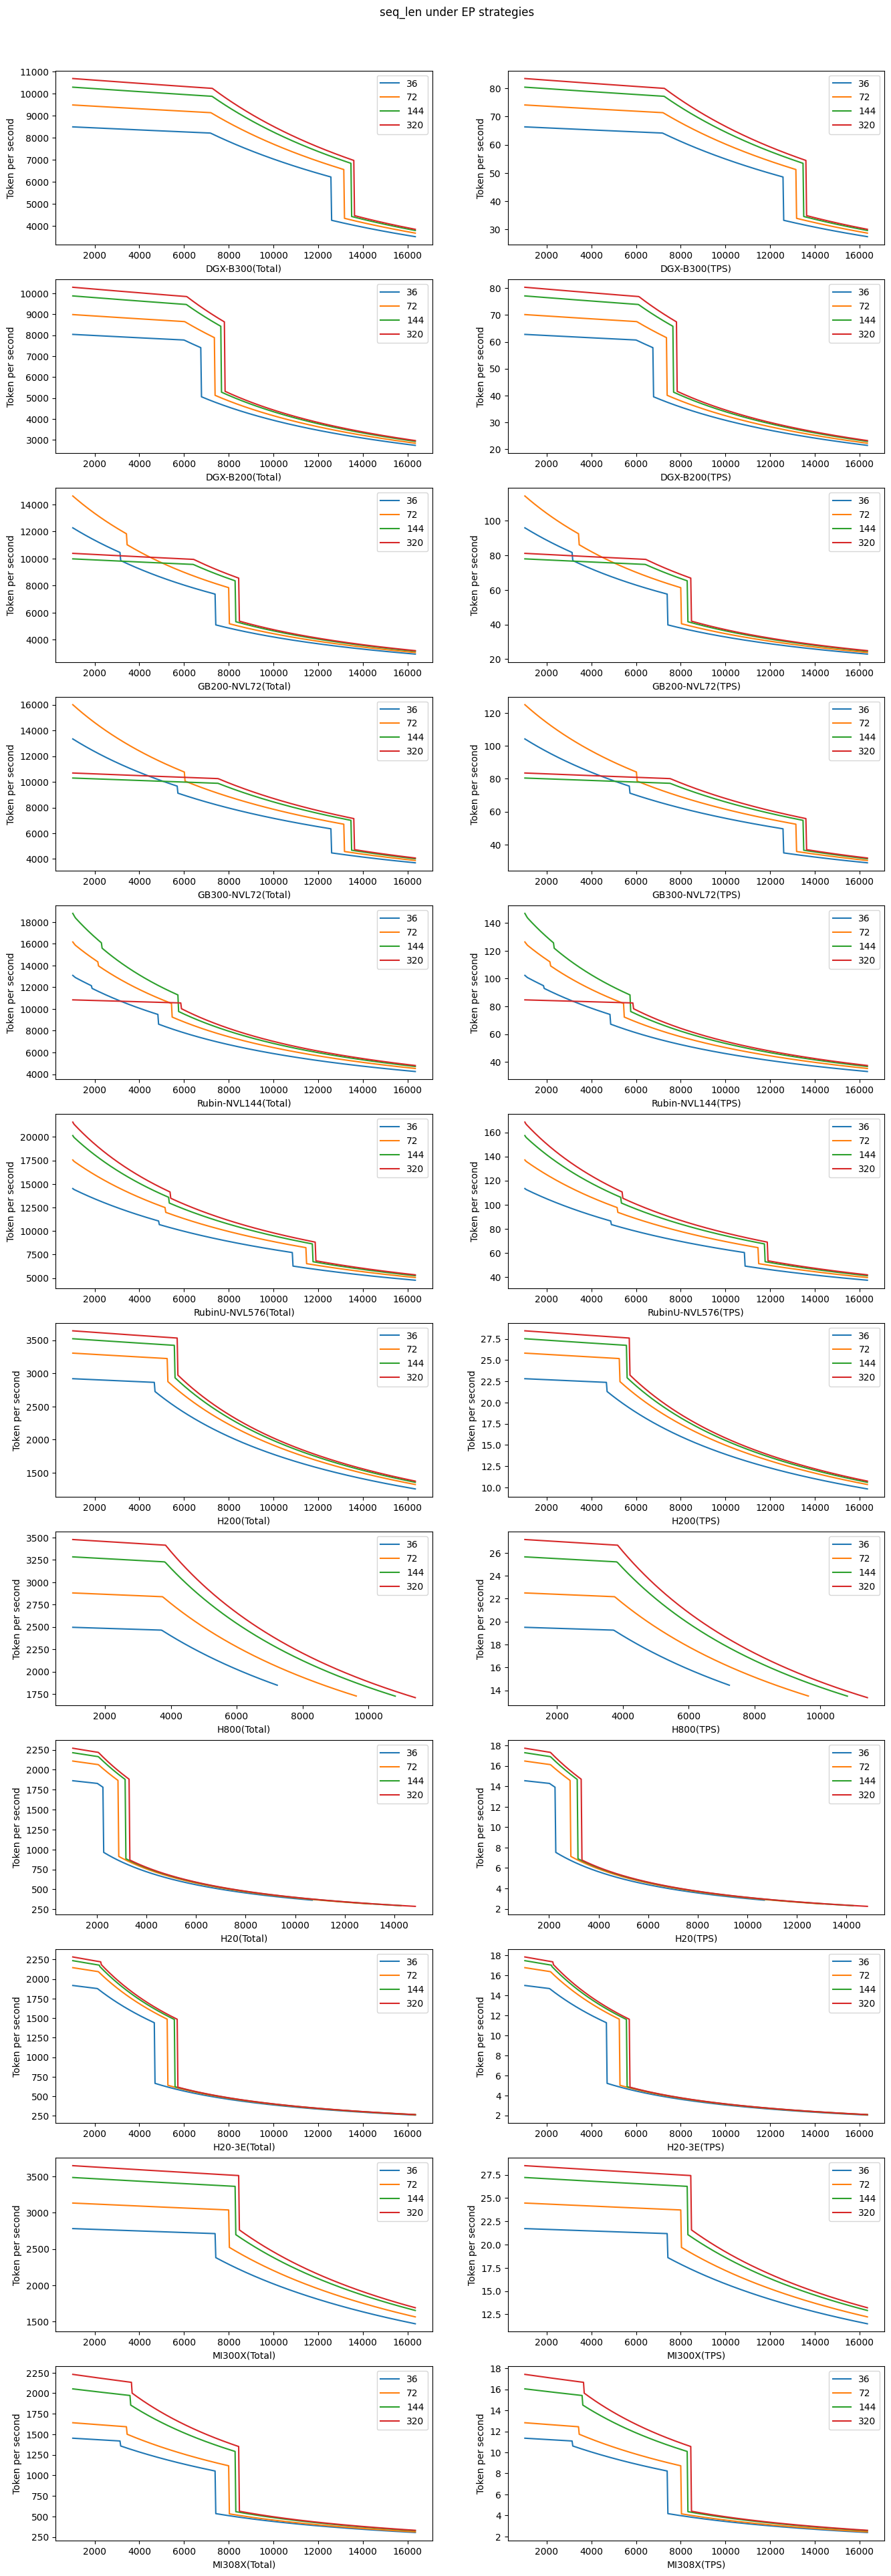

In [11]:
#gpu_all_decode = sb.get_gpu_info('./device/gpu_info.csv',
#                                 device_list=['GB300-NVL72','H800','H20'],
#                                 decoding_mode=True) 

sb.draw(df1, gpu_all_decode, 
        comp_name='EP',comp_val_list=[36,72,144,320],
        val_list=['Total','TPS'],val_unit_name='Token per second',
        title='seq_len under EP strategies',savefig=True,filename='seq_len.png')

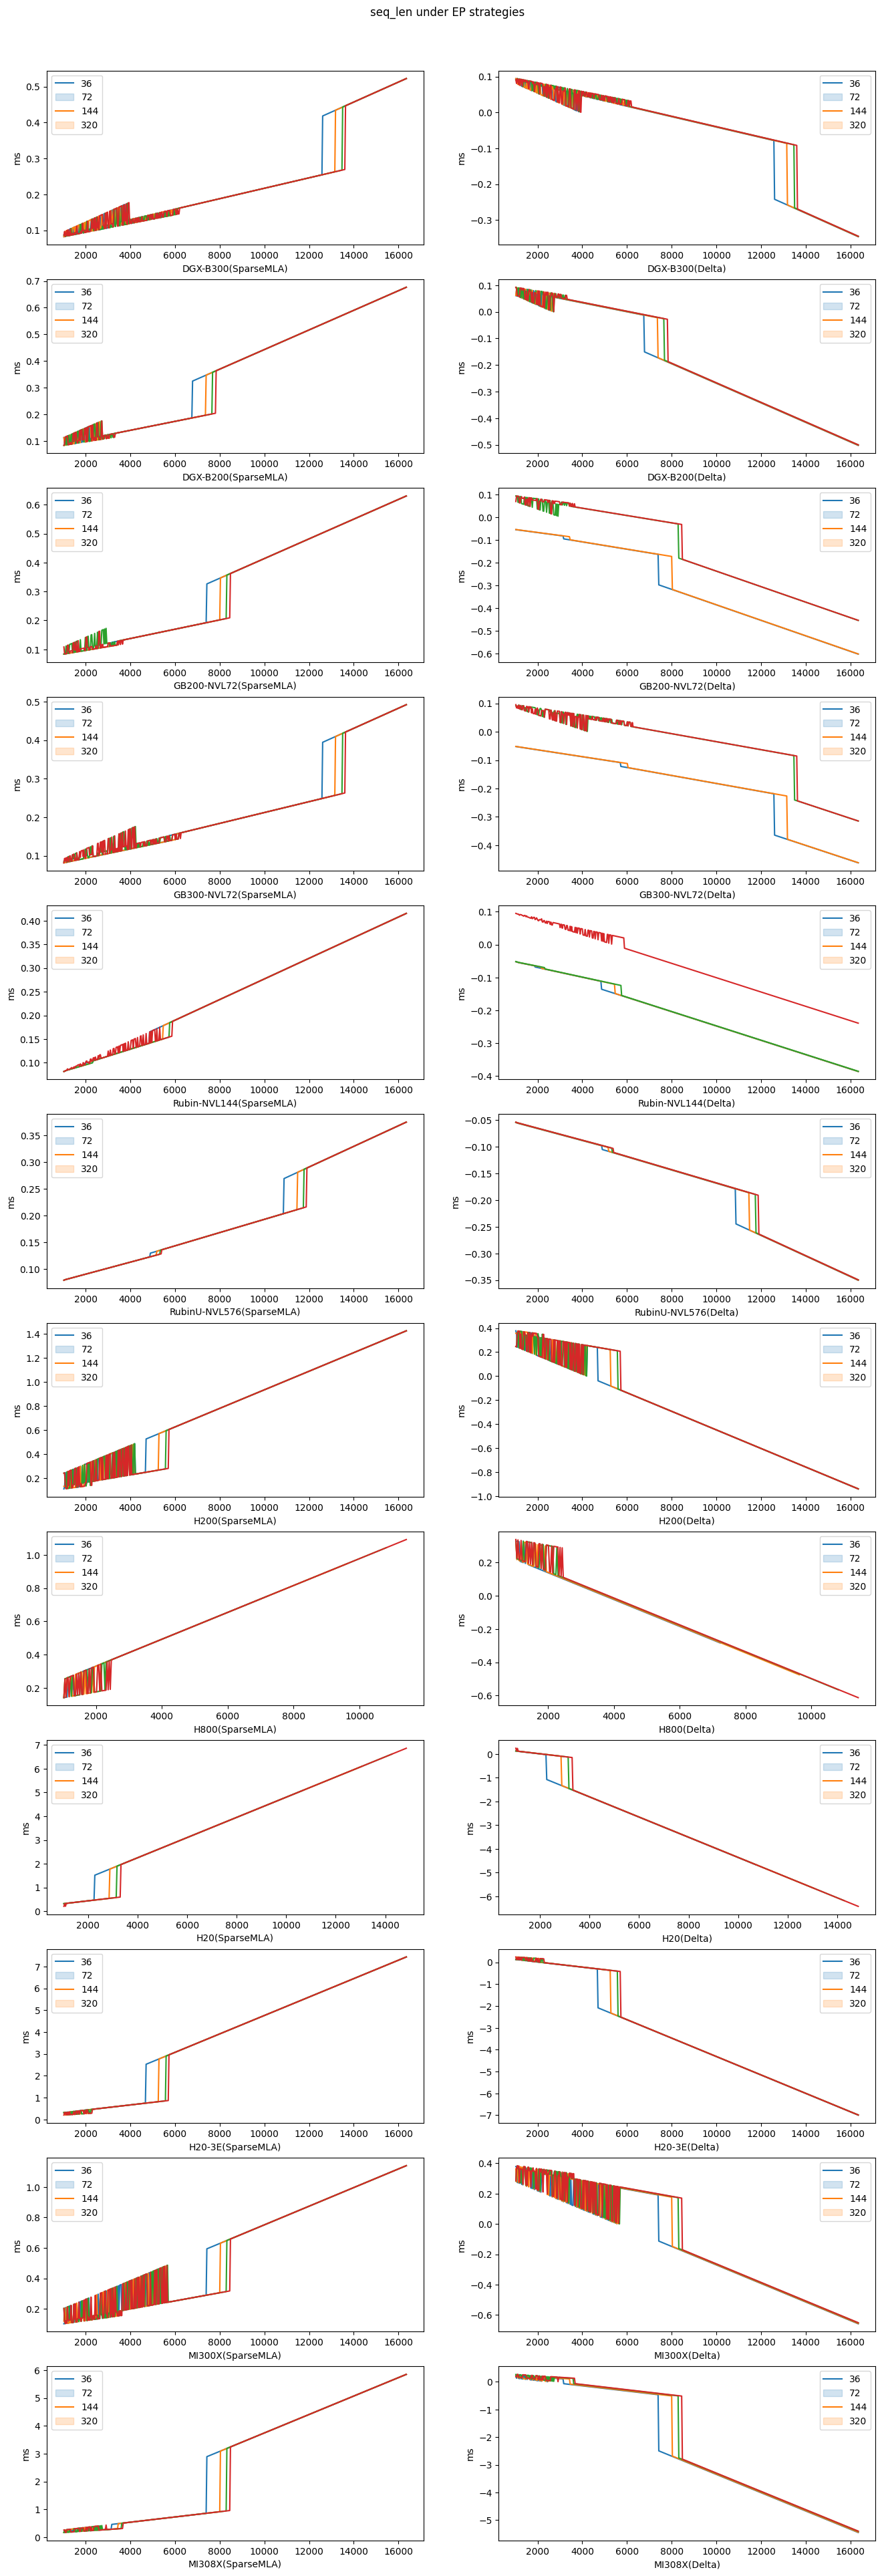

In [7]:
sb.draw(df1, gpu_all_decode, 
        comp_name='EP',comp_val_list=[36,72,144,320],
        val_list=['SparseMLA','Delta'],val_unit_name='ms',
        title='seq_len under EP strategies')